In [1]:
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
import mpu.ml

from nltk.tokenize import TweetTokenizer
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Ensures that tweet and user ids do not appear in scientific notation
pd.options.display.float_format = '{:.0f}'.format

# CNN Baseline Model

In [7]:
train = pd.read_csv('../NLP_MBTI_Classification/twisty_train.csv', index_col=0)
#train = train[train['language'] == language]
train

,confirmed_tweet_ids,user_id,mbti,twitter_text,language
14222,559463518056222720,27621196,ISFJ,@alicedeee Ich könnte der stundenlang zuhören!...,German
14668,473510634081239040,855190290,ENFP,@Moaxi @KatrinaJulie kann ich immer noch sehen...,German
889,377531414130229248,133708993,ENFJ,@GerhardMaier fand ich auch damals. Klappt das...,German
7705,578258496380149760,397366447,ENFP,38 qm für 700 warm ... ich muss verrückt sein ...,German
1585,662601975658344448,1305617798,INTP,@dilettiert Willkommen in unserer Welt. Liebe ...,German
...,...,...,...,...,...
13586,680949466871009280,542772869,INTP,accorsi la deve smettere,Dutch
8513,635612601947394048,169452362,INFP,io vado col finale\nlo faccio\nchiudo alle 4 m...,Dutch
1371,466726191257636864,98672812,ENTJ,L'evoluzione dell'Universo in una simulazione ...,Dutch
4695,561655376605872064,548470145,ESFJ,E dopo essermi addormentata fra le tue braccia...,Dutch


In [8]:
test = pd.read_csv('../NLP_MBTI_Classification/twisty_test.csv', index_col=0)
#test = test[test['language'] == language]
test

,confirmed_tweet_ids,user_id,mbti,twitter_text,language
8856,158679079082659840,62117549,ENTP,Wisst ihr was das beste an #ibes ist? Dass sie...,German
15218,597014706436612096,17832573,ENFP,Ich hab Connis 7 Minuten letztes Jahr auch geh...,German
3635,134641950128214000,81568595,ENFP,"@fat_jacK47 ja, aber ich wärs nich :D",German
1065,242712774025809920,3253641,ESTJ,@Wally44 danke. Ist runtergeladen :),German
1588,608464865997549568,3091403585,ISTP,@Patienti_A Schlaf gut,German
...,...,...,...,...,...
13638,642030068894691328,1327151641,ENTP,quel momento in cui stai pedalando tranquillam...,Dutch
18491,260711964781731840,548470145,ESFJ,uomo perfetto????? FA SCHIFOOOOOOOOOOOOOOOOOOO...,Dutch
6374,692631634366038016,201361241,INTJ,"@amerutan non ti allarmare, sto accompagnando ...",Dutch
12934,671954187303919616,164412025,INFJ,- insegnarle l'italiano e avevo tipo otto anni...,Dutch


In [9]:
mbti_num_encoding = {
    'ISTJ':0, 'ISFJ':1, 'INFJ':2, 'INTJ':3,
    'ISTP':4, 'ISFP':5, 'INFP':6, 'INTP':7,
    'ESTP':8, 'ESFP':9, 'ENFP':10, 'ENTP':11,
    'ESTJ':12, 'ESFJ':13, 'ENFJ':14, 'ENTJ':15}

In [10]:
train['mbti_encoding'] = train['mbti'].apply(lambda x: mbti_num_encoding[x])
test['mbti_encoding'] = test['mbti'].apply(lambda x: mbti_num_encoding[x])

In [11]:
train = train[['twitter_text', 'mbti_encoding']]
train

,twitter_text,mbti_encoding
14222,@alicedeee Ich könnte der stundenlang zuhören!...,1
14668,@Moaxi @KatrinaJulie kann ich immer noch sehen...,10
889,@GerhardMaier fand ich auch damals. Klappt das...,14
7705,38 qm für 700 warm ... ich muss verrückt sein ...,10
1585,@dilettiert Willkommen in unserer Welt. Liebe ...,7
...,...,...
13586,accorsi la deve smettere,7
8513,io vado col finale\nlo faccio\nchiudo alle 4 m...,6
1371,L'evoluzione dell'Universo in una simulazione ...,15
4695,E dopo essermi addormentata fra le tue braccia...,13


In [12]:
test = test[['twitter_text', 'mbti_encoding']]
test

,twitter_text,mbti_encoding
8856,Wisst ihr was das beste an #ibes ist? Dass sie...,11
15218,Ich hab Connis 7 Minuten letztes Jahr auch geh...,10
3635,"@fat_jacK47 ja, aber ich wärs nich :D",10
1065,@Wally44 danke. Ist runtergeladen :),12
1588,@Patienti_A Schlaf gut,4
...,...,...
13638,quel momento in cui stai pedalando tranquillam...,11
18491,uomo perfetto????? FA SCHIFOOOOOOOOOOOOOOOOOOO...,13
6374,"@amerutan non ti allarmare, sto accompagnando ...",3
12934,- insegnarle l'italiano e avevo tipo otto anni...,2


# Creating Multilingual Word Embedding Matrix

Aligned Word Vector (fastText): https://fasttext.cc/docs/en/aligned-vectors.html

Gensim API: https://radimrehurek.com/gensim/apiref.html

In [13]:
max_word_limit = 50000 # Limit due to kernal memory constraint
model1 = gensim.models.KeyedVectors.load_word2vec_format('wiki.de.align.vec', limit=max_word_limit)
model2 = gensim.models.KeyedVectors.load_word2vec_format('wiki.es.align.vec', limit=max_word_limit)
model3 = gensim.models.KeyedVectors.load_word2vec_format('wiki.it.align.vec', limit=max_word_limit)
model4 = gensim.models.KeyedVectors.load_word2vec_format('wiki.nl.align.vec', limit=max_word_limit)

In [14]:
def wordvec_embedding_matrix(model):
    # initialize embedding matrix and word-to-id map:
    embedding_matrix = np.zeros((max_word_limit + 1, 300))       
    vocab_dict = {}

    # build the embedding matrix and the word-to-id map:
    for i, word in enumerate(model.vocab.keys()):
        embedding_vector = model[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            vocab_dict[word] = i
    
    return (embedding_matrix, vocab_dict)

In [15]:
em1, vd1 = wordvec_embedding_matrix(model1)
em2, vd2 = wordvec_embedding_matrix(model2)
em3, vd3 = wordvec_embedding_matrix(model3)
em4, vd4 = wordvec_embedding_matrix(model4)

embedding_matrix = np.vstack([em1, em2, em3, em4])

In [16]:
vocab_dict = {**vd1, **vd2, **vd3, **vd4}

# Tokenize Text

In [17]:
# Split data into twitter text and mbti number encoding
X_train = train['twitter_text']
y_train = train['mbti_encoding']

X_test = test['twitter_text']
y_test = test['mbti_encoding']

# Convert number encoding to one hot vector
#import mpu.ml
y_train = np.array(mpu.ml.indices2one_hot(y_train, nb_classes=16))
y_test = np.array(mpu.ml.indices2one_hot(y_test, nb_classes=16))

In [18]:
# Twitter tokenizer specific for tweets
# preserve_case=False converts everything to lowercase
# strip_handles remove Twitter username handles from text
# reduce_len=True replace repeated character sequences of length 3 or greater with sequences of length 3
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# This is to identify the longest token sequence after the tokenizer has been applied to it
# This number will be used for padding and initial configuration of CNN model below
#MAX_SEQUENCE_LENGTH = 0
#for sentence in train['twitter_text']:
#    token_length = len(tokenizer.tokenize(sentence))
#    MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, token_length)
    
#for sentence in test['twitter_text']:
#    token_length = len(tokenizer.tokenize(sentence))
#    MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, token_length)

# Due to computational limitations, MAX_SEQUENCE_LENGTH has already been precalculated
MAX_SEQUENCE_LENGTH = 52
print("Max token length:", MAX_SEQUENCE_LENGTH)

Max token length: 52


In [19]:


def sents_to_ids(sentences):
    """
    converting a list of strings to a list of lists of word ids
    """
    max_length = MAX_SEQUENCE_LENGTH
    text_ids = np.zeros((1, max_length), dtype=int)
    for sentence in sentences:
        example = []
        for word in tokenizer.tokenize(sentence):
            if word in vocab_dict.keys():
                example.append(vocab_dict[word])
            #else:
            #    example.append(0)

        example = np.pad(example, (0, max_length-len(example)))
        text_ids = np.vstack((text_ids, example))
    
    text_ids = np.delete(text_ids, 0, axis=0)

    return text_ids

X_train = sents_to_ids(X_train)
X_test = sents_to_ids(X_test)

# Train CNN NLP Model

Example of CNN: https://github.com/datasci-w266/2021-spring-main/blob/master/materials/lesson_notebooks/lesson_5_cnn.ipynb

https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [20]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

def cnn_model(optimizer='adam', epochs_input=30, batch_size_input=32, under_represented_weighting=False):
    
    # CNN Model Architecture
    tf_model = tf.keras.Sequential()
    tf_model.add(embedding_layer)
    tf_model.add(tf.keras.layers.Conv1D(
                filters=10, 
                kernel_size=3, 
                strides=1, 
                padding='same', 
                activation='relu', 
                use_bias=True,
                kernel_initializer='glorot_uniform', 
                bias_initializer='zeros')) 
    tf_model.add(tf.keras.layers.GlobalMaxPooling1D())
    tf_model.add(Dense(100, activation='relu'))
    tf_model.add(Dense(16, activation='sigmoid'))
    
    tf_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    
    if under_represented_weighting != False:
        # Class weight helps to tell the model to "pay more attention" to samples from an under-represented class.
        # Reduces training accuracy but prevents model just predicting the most popular mbti classification
        # Average accuracy (5th mbti metric below) stays constant with or without the weighting

        #from sklearn.utils.class_weight import compute_class_weight
        #weights_array = compute_class_weight('balanced', 
        #                       classes=np.arange(16), 
        #                       y=np.argmax(y_train, axis=1))
        #weights = dict(zip(np.arange(16), weights_array))
        tf_model.fit(X_train, y_train, 
                           validation_data=(X_test, y_test), 
                           class_weight=under_represented_weighting,
                           epochs=epochs_input, 
                           batch_size=batch_size_input)
        
    else:
        tf_model.fit(X_train, y_train, 
                           validation_data=(X_test, y_test), 
                           epochs=epochs_input, 
                           batch_size=batch_size_input)
        
    return tf_model

In [21]:
weights_array = compute_class_weight('balanced', 
                       classes=np.arange(16), 
                       y=np.argmax(y_train, axis=1))
weights = dict(zip(np.arange(16), weights_array))

In [24]:
cnn_history = cnn_model(epochs_input=30, batch_size_input=256, under_represented_weighting=weights)

Epoch 1/30
313/313 [==============================] - 29s 92ms/step - loss: 2.7431 - accuracy: 0.0838 - val_loss: 2.6941 - val_accuracy: 0.1292
Epoch 2/30
313/313 [==============================] - 29s 92ms/step - loss: 2.6791 - accuracy: 0.1303 - val_loss: 2.6637 - val_accuracy: 0.1370
Epoch 3/30
313/313 [==============================] - 29s 91ms/step - loss: 2.6549 - accuracy: 0.1302 - val_loss: 2.6799 - val_accuracy: 0.1280
Epoch 4/30
313/313 [==============================] - 28s 91ms/step - loss: 2.6333 - accuracy: 0.1284 - val_loss: 2.7258 - val_accuracy: 0.1000
Epoch 5/30
313/313 [==============================] - 29s 91ms/step - loss: 2.6124 - accuracy: 0.1217 - val_loss: 2.7287 - val_accuracy: 0.0962
Epoch 6/30
313/313 [==============================] - 29s 91ms/step - loss: 2.5926 - accuracy: 0.1181 - val_loss: 2.7381 - val_accuracy: 0.0839
Epoch 7/30
313/313 [==============================] - 29s 91ms/step - loss: 2.5741 - accuracy: 0.1146 - val_loss: 2.7234 - val_accuracy:

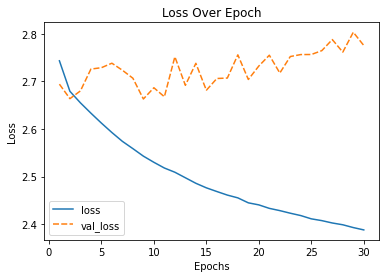

In [25]:
#cnn_history.summary()
df_cnn_history = pd.DataFrame(cnn_history.history.history)
df_cnn_history.index = np.arange(1, len(df_cnn_history)+1)

plt.title('Loss Over Epoch')
sns.lineplot(data=df_cnn_history[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Loss');

# Model and Error Analysis

In [26]:
def mbti_accuracy(y_true, y_pred):
    # Measures accuracy for mbti classification across 5 accuracy metrics:
    # one match, two matches, three matches, perfect match, average match
    
    # Average match is number of letters match / 4
    
    # Comparing 'ENFJ' as the true class and 'ENFP' as the predicted class,
    # this function returns...
    # [1, 1, 1, 0, 0.75]
     
    # Get index from one hot encoding of y_true
    # Get index of highest softmax/probability output in y_pred
    y_true_index = np.argmax(y_true, axis=1)
    y_pred_index = np.argmax(y_pred, axis=1)
    
    # Use the index to identify the corresponding mbti class
    mbti_num_encoding_list = list(mbti_num_encoding)
    y_true_mbti = [mbti_num_encoding_list[idx] for idx in y_true_index]
    y_pred_mbti = [mbti_num_encoding_list[idx] for idx in y_pred_index]
    
    one_match = []
    two_matches = []
    three_matches = []
    perfect_match = []
    
    # Perform mbti accuracy measurements
    sum_num_matches = 0
    for i in np.arange(len(y_true_mbti)):
        num_letter_matches = len(set(y_true_mbti[i]) & set(y_pred_mbti[i]))
        
        # At least 1 letter match
        if num_letter_matches == 1:
            one_match += [True]
            two_matches += [False]
            three_matches += [False]
            perfect_match += [False]
            
        # At least 2 letter matches
        elif num_letter_matches == 2:
            one_match += [True]
            two_matches += [True]
            three_matches += [False]
            perfect_match += [False]
            
        # At least 3 letter matches
        elif num_letter_matches == 3:
            one_match += [True]
            two_matches += [True]
            three_matches += [True]
            perfect_match += [False]
           
        # Perfect match
        else:
            one_match += [True]
            two_matches += [True]
            three_matches += [True]
            perfect_match += [True]
        
    # Average/partial matches
        sum_num_matches += num_letter_matches
    avg_num_matches = sum_num_matches/(len(y_true_mbti)*4)*100
    
    return np.round([np.mean(one_match)*100, 
                     np.mean(two_matches)*100, 
                     np.mean(three_matches)*100, 
                     np.mean(perfect_match)*100, 
                     avg_num_matches], 
                    2)


In [27]:
training_acc_metrics = np.append(np.array(['Train', 'All', 'CNN', X_train.shape[0]]), 
                                 mbti_accuracy(y_train, cnn_history.predict(X_train)))
testing_acc_metrics = np.append(np.array(['Test', 'All', 'CNN', X_test.shape[0]]),
                                mbti_accuracy(y_test, cnn_history.predict(X_test)))

acc_metrics = np.vstack((training_acc_metrics, testing_acc_metrics))

acc_metrics_summary = pd.DataFrame(acc_metrics, columns=['Data',
                                                         'Language',
                                                         'Model',
                                                         'Number of Samples',
                                                         'At Least 1 Match', 
                                                         'At Least 2 Matches', 
                                                         'At Least 3 Matches', 
                                                         'Perfect Match', 
                                                         'Average Match'])
acc_metrics_summary

,Data,Language,Model,Number of Samples,At Least 1 Match,At Least 2 Matches,At Least 3 Matches,Perfect Match,Average Match
0,Train,All,CNN,80000,100.0,76.19,40.12,17.99,52.52
1,Test,All,CNN,20000,100.0,74.63,36.33,13.3,49.65


In [32]:
filepath = '../NLP_MBTI_Classification/results_summary/'

In [33]:
csv_filepath = filepath+'cnn_'+'all'+'_summary.csv'
acc_metrics_summary.to_csv(csv_filepath)

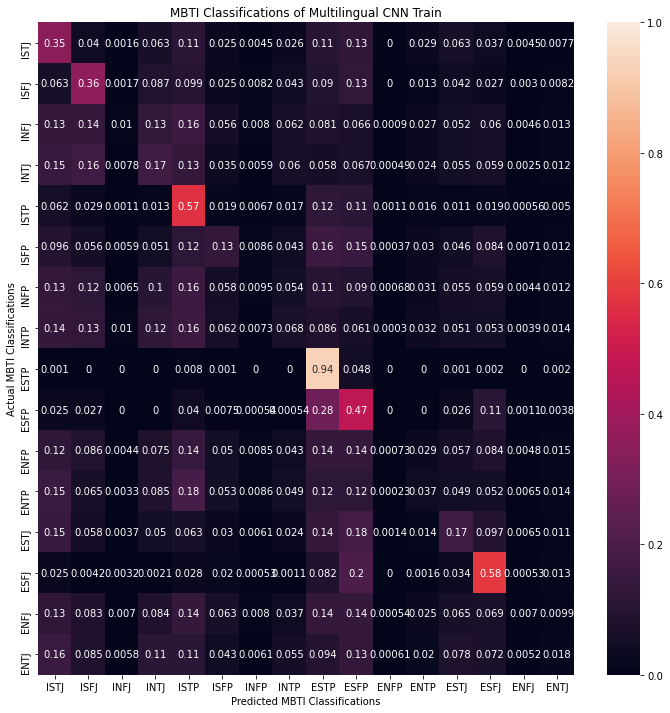

In [34]:
cf_matrix = confusion_matrix(np.argmax(y_train, axis=1), 
                             np.argmax(cnn_history.predict(X_train), axis=1),
                             normalize='true')


plt.figure(figsize=(12, 12))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels=list(mbti_num_encoding),
            yticklabels=list(mbti_num_encoding),
            vmin=0, vmax=1)
plt.title("MBTI Classifications of Multilingual CNN Train")
plt.ylabel("Actual MBTI Classifications")
plt.xlabel("Predicted MBTI Classifications")

matrix_train_filepath = filepath+'cnn_'+'all'+'_train'+'_confusion_matrix.png'
plt.savefig(matrix_train_filepath, transparent=True);

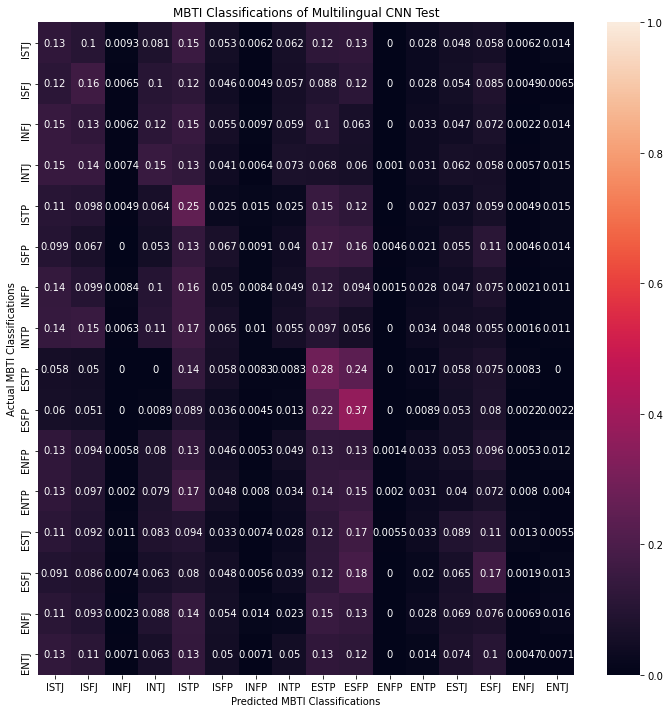

In [35]:
cf_matrix = confusion_matrix(np.argmax(y_test, axis=1), 
                             np.argmax(cnn_history.predict(X_test), axis=1),
                             normalize='true')


plt.figure(figsize=(12, 12))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels=list(mbti_num_encoding),
            yticklabels=list(mbti_num_encoding),
            vmin=0, vmax=1)
plt.title("MBTI Classifications of Multilingual CNN Test")
plt.ylabel("Actual MBTI Classifications")
plt.xlabel("Predicted MBTI Classifications")

matrix_test_filepath = filepath+'cnn_'+'all'+'_test'+'_confusion_matrix.png'
plt.savefig(matrix_test_filepath, transparent=True);